In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F 

import torchvision
import torchvision.transforms as transforms # 데이터 전처리
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
train_dataset = torchvision.datasets.FashionMNIST("data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("data", download=False, transform=transforms.Compose([transforms.ToTensor()]))

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.6%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



119.3%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [11]:
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

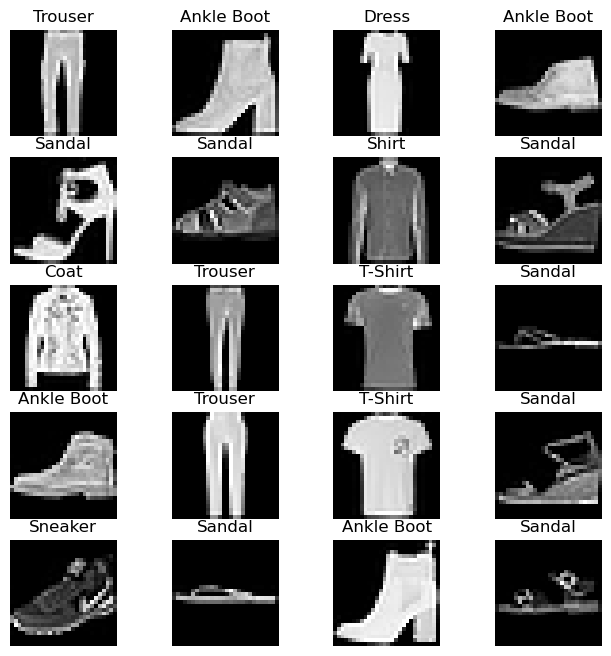

In [12]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'} # 클래스 10개

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
plt.show()

In [15]:
# ConvNet 적용되지 않은 네트워크
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

print(FashionDNN())

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
lr = 0.001
model = FashionDNN()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
# DNN

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accracy_list = []

prediction_list = []
labels_list = []


for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # autograd.Variable은 현재 deprecated 되었다. Tensor에서 미분을 기본적으로 지원한다. 
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        pred = model(train)
        loss = loss_fn(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count+=1
        
        if not (count % 50):
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                
                pred = model(test)
                predictions = torch.max(pred, 1)[1].to(device)
                prediction_list.append(predictions)
                
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accracy_list.append(accuracy)
            
        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%')

Iteration: 500, Loss: 0.5649879574775696, Accuracy: 85.21500396728516%
Iteration: 1000, Loss: 0.4174642264842987, Accuracy: 85.99666595458984%
Iteration: 1500, Loss: 0.34683454036712646, Accuracy: 86.6050033569336%
Iteration: 2000, Loss: 0.3448096811771393, Accuracy: 87.24500274658203%
Iteration: 2500, Loss: 0.2779914140701294, Accuracy: 87.72000122070312%
Iteration: 3000, Loss: 0.28604352474212646, Accuracy: 88.43333435058594%


In [21]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
print(FashionCNN())
        

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [22]:
lr = 0.001
model = FashionCNN()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# CNN
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accracy_list = []

prediction_list = []
labels_list = []


for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # autograd.Variable은 현재 deprecated 되었다. Tensor에서 미분을 기본적으로 지원한다. 
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        pred = model(train)
        loss = loss_fn(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count+=1
        
        if not (count % 50):
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                
                pred = model(test)
                predictions = torch.max(pred, 1)[1].to(device)
                prediction_list.append(predictions)
                
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accracy_list.append(accuracy)
            
        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%')

c:\Users\Hyeonseok\anaconda3\envs\torch_study\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 500, Loss: 0.49830782413482666, Accuracy: 87.66333770751953%
Iteration: 1000, Loss: 0.349934458732605, Accuracy: 89.96833801269531%
Iteration: 1500, Loss: 0.27853479981422424, Accuracy: 90.36000061035156%
Iteration: 2000, Loss: 0.17759829759597778, Accuracy: 91.86333465576172%
Iteration: 2500, Loss: 0.13244786858558655, Accuracy: 92.19000244140625%
Iteration: 3000, Loss: 0.1697888821363449, Accuracy: 93.2366714477539%
